# RL PRACTICE ➡️ Pig Dice Game | Pass the Pigs (`numba`version)

<div class="alert alert-info">
<h2>Objective</h2>
<p>Find and optimal policy for playing the game (in either of the possible variants: <code>GAME_PIG_DICE</code> or <code>GAME_PASS_THE_PIGS</code>)  using a RL Dynamic Programming algorithm</p>  
<p>You can choose either a <code>Policy Iteration & Improvement</code> algorithm or a<code>Value Iteration</code> algorithm</p>  
<p>Review the general documentation included in the assingment description for obtaining a general inutition of the mechanics of the game</p>  
<h2>Notes</h2>
<p>🟨 For guiding and helping you in understanding the types of <b>representations</b> (states, actions, policies) used and the <b>system dynamics</b> of the environment you are provided with some code for examples of policies [Policy helpers (opponent's policies)] and for the transitioning rules of the game [Basic simplified environment ➡️ As numba functions]</p>  
<p>🟨 You will not need such functions but, however, you might just need to include (copy) pieces of this code into your final algorithm for implementing the sweeps of state/action/state transitions in your algorithm</p>
<p>🟨 Additionally, you are provided with a basic example for the visualization of the resulting policies [Utility and plotting functions]. You may use those or either implement other specific tools/plots that you consider more convenient for the visualization, interpretation or explanation of the policies obtained</p>  
<p>🟨 The code is adapted for <code>numba</code> for faster execution, but in this case you can implement your algorithms practically with no change from standard python syntax. In the case, that you find difficulties or error that make the debugging process more complicated, just comment out the <code>@njit</code> decorators</p>
<hr>
<strong>
Review the notebook and fill in the missing code appropriately.<br>
Check the final executability and results of the resulting code.
</strong></div>

## Imports and variables

In [4]:
# ------------------------------------------------------------
# Two-player Pig (current-player view), Dynamic Programming (value iteration)
# and Q-learning via self-play. Compares vs "hold at 25" heuristic.
# Produces 3D policy plots for each policy.

# from __future__ import annotations
import math, random, time
from collections import defaultdict
import typing
from typing import Dict, Tuple, Literal

import numpy as np
import pickle

import numba
from numba import njit, typed, types # jit, prange, objmode
from numba import int32, float32    # import the basic types for numba specs
from numba.experimental import jitclass
# from numba.typed import Dict, List
"""
https://numba.readthedocs.io/en/stable/index.html
In @njit(nopython=True) functions, globals are treated as compile-time constants. 
You can read certain globals, but you generally cannot rebind them, and many Python containers are not supported.
⚠️ You may be able to mutate the contents of a global NumPy array inside @njit, but you cannot reassign the global name. 
It’s safer and clearer to pass arrays (or typed.Dict) as arguments (passed by reference)
"""
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

# -----------------------------
# Global configuration
# -----------------------------
GAMMA = 0.99         # almost undiscounted episodic game
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
RNG = random.Random(SEED)  # reproducible; change/seed as you like

# ----------------------------
# Game configuration
# ----------------------------
GOAL = 100
ROLL, HOLD = 0, 1
ACTIONS = (ROLL, HOLD)

GAME_PIG_DICE      = 0
GAME_PASS_THE_PIGS = 1
GAME = GAME_PASS_THE_PIGS
GAME = GAME_PIG_DICE

if GAME == GAME_PIG_DICE:
    DIE_SIDES = 6
    PIG_OUT  = 1
    outcomes = tuple(range(1,DIE_SIDES+1))
    out_prob = tuple([1.0/DIE_SIDES]*DIE_SIDES)
elif GAME == GAME_PASS_THE_PIGS:
    # OUTS      = ('PIG_OUT','PIGGYBACK','OINKER')
    PIGGYBACK = -2
    OINKER    = -1
    PIG_OUT   = 0
    # abridged system dynamics
    outcomes = (PIGGYBACK, OINKER, PIG_OUT, 1, 5, 10, 15, 20, 25, 40, 60)
    out_prob = (0.001, 0.0386, 0.1922, 0.1922, 0.31, 0.1168, 0.0846, 0.0525, 0.0056, 0.0049, 0.0016)

# If True, a player wins immediately if their *running* score (score+turn_total) reaches GOAL during the turn (without needing to hold). 
# If False, they must hold to bank.
INSTANT_WIN_ON_ROLL = True    

OUT_ARR  = np.array(outcomes, dtype=np.int64)
PROB_ARR = np.array(out_prob, dtype=np.float64)

# ----------------------------
# RL Definitions
# ----------------------------
State  = Tuple[int, int, int]  # (me, opp, turn) # always from the point of view of Player A (me)
Bucket = Tuple[int, int, int]  # (me, opp, turn)
Policy  = np.ndarray # Dict[Tuple[int,int,int], int or float] # the "float" case is just for being able of holding np.nan (for some better 3d plots)
QValues = np.ndarray # Dict[Tuple[int,int,int], list of floats]

BUCKET = 10 # Points (for grouping scores into buckets)
MAX_BUCKETS = GOAL//BUCKET

## Policy helpers (opponent's policies)

In [5]:
# policy_roller() can be built as policy_hold_at_(GOAL)    
# policy_random() can be built as policy_hold_at_(randomize=True)    
def policy_hold_at_(threshold=25, randomize=False) -> np.ndarray: # Dict[State, Action]
    """Heuristic policy: hold if turn >= 25; always hold if can immediately win."""
    # P: Dict[State, int] = {}
    P = np.ones((GOAL,GOAL,GOAL),dtype=float)*HOLD # *np.nan # default is HOLD
    for me in range(GOAL):
        for opp in range(GOAL):
            max_turn = GOAL - 1 - me
            for turn in range(max_turn + 1):
                if me + turn >= GOAL:
                    P[(me, opp, turn)] = HOLD
                else:
                    if randomize:
                        P[(me, opp, turn)] = HOLD if turn >= random.randint(0,GOAL) else ROLL
                        # or alternatively...
                        # P[(me, opp, turn)] = HOLD if random.random() >= 0.5 else ROLL 
                    else:
                        P[(me, opp, turn)] = HOLD if turn >= threshold else ROLL
    return P

## Basic simplified environment ➡️ As `numba` functions

In [6]:
# -----------------------------
# Environment (current-player view)
# -----------------------------
@njit(fastmath=True)
def choice_weighted_idx(prob):
    # prob: 1D array of non-negative weights (need not sum to 1)
    L = len(prob)
    total = 0.0
    for i in range(L): total += prob[i]
    u = np.random.random() * total
    c = 0.0
    for i in range(L):
        c += prob[i]
        if u < c: return i
    return L - 1  # guard for rounding
    
@njit(fastmath=True)
def reset() -> Tuple[State, typing.Dict[str,int]]:
    return (0, 0, 0), {}

@njit(fastmath=True)
def step_1(s: State, a: int) -> Tuple[State, int, bool, bool, typing.Dict[str,int]]:
    """
    One environment step from state s using action a.
    Returns (next_state, reward, terminated, truncated, info) --> truncated means swap turns

    Reward is from the perspective of the *actor* at s:
    +1 if the actor wins, -1 if the actor loses, else 0.
    """
    me, opp, turn = s

    # Terminal guard (shouldn't be called on terminal states)
    if me >= GOAL:
        print('ERROR! Attempting a terminal state')   
        return s, +1, True, False, {'swap':0}
    if opp >= GOAL:
        print('ERROR! Attempting a terminal state')   
        return s, -1, True, False, {'swap':0}

    if a == HOLD:
        # Bank turn; if enough to win -> terminal +1
        if me + turn >= GOAL:
            return (me + turn, opp, 0), +1, True, False, {'swap':0}
        # Otherwise pass turn: roles swap => next current player is the (previous) opponent
        return (opp, me + turn, 0), 0, False, True, {'swap':1}
    
    # +-------------------------------------+
    # |         System Dynamics             |
    # +-------------------------------------+
    # a == "roll"
    if GAME == GAME_PIG_DICE:
        # d = random.randint(1, DIE_SIDES)
        # d = np.random.choice(outcomes, 1, p=out_prob)[0]
        # d = random.choices(outcomes, weights=out_prob, k=1)[0]
        d = outcomes[choice_weighted_idx(out_prob)]
        if d == PIG_OUT:
            # Pig out: lose running total, pass turn (roles swap)
            return (opp, me, 0), 0, False, True, {'swap':1}
        if me + turn + d >= GOAL:
            return (me + turn + d, opp, 0), +1, True, False, {'swap':0}
        return (me, opp, turn + d), 0, False, False, {'swap':0}
    elif GAME == GAME_PASS_THE_PIGS:    
        # abridged system dynamics
        # outcomes = [PIGGYBACK, OINKER, PIG_OUT, 1, 5, 10, 15, 20, 25, 40, 60]
        # out_prob = [0.001, 0.0386, 0.1922, 0.1922, 0.31, 0.1168, 0.0846, 0.0525, 0.0056, 0.0049, 0.0016]
        # d = np.random.choice(outcomes, 1, p=out_prob)[0]    
        d = outcomes[choice_weighted_idx(out_prob)]
        if d == PIGGYBACK: # Player is eliminated  (roles swap)
            return (opp, 0, 0), -1, True, False, {'swap':0}
        elif d == OINKER: # (Back to Zero) Player's total score from the game is wiped out
            return (opp, 0, 0), 0, False, True, {'swap':1}
        elif d == PIG_OUT: # Pigs lie on opposite sides --> Player's score for the turn is wiped out
            # Pig out: lose running total, pass turn (roles swap)
            return (opp, me, 0), 0, False, True, {'swap':1}
        elif me + turn + d >= GOAL:
            return (me + turn + d, opp, 0), +1, True, False, {'swap':0}
        else:
            return (me, opp, turn + d), 0, False, False, {'swap':0}
    print('ERROR! Undefined step return')   
    return (0, 0, 0), 0, False, False, {'swap':0}

# example...
step_1((0,1,2), HOLD)            

((1, 2, 0), 0, False, True, DictType[unicode_type,int64]<iv=None>({swap: 1}))

## Formal MDP Formulation

### 1. State Space ($\mathcal{S}$)
The state $s \in \mathcal{S}$ is defined from the perspective of the current player as a tuple:
$$s = (\text{me}, \text{opp}, \text{turn})$$

* **$\text{me}$**: Current player's banked score (**0** to **$\text{GOAL}-1$**).
* **$\text{opp}$**: Opponent's banked score (**0** to **$\text{GOAL}-1$**).
* **$\text{turn}$**: Points accumulated during the current turn, not yet banked.
* **Non-Terminal States**: $\text{me} < \text{GOAL}$, $\text{opp} < \text{GOAL}$, and $\text{me} + \text{turn} < \text{GOAL}$.
* **Terminal States**: Any state where $\text{me} \ge \text{GOAL}$ (Win) or $\text{opp} \ge \text{GOAL}$ (Loss). If `INSTANT_WIN_ON_ROLL` is True, reaching **GOAL** mid-roll is also a terminal win.

### 2. Action Space ($\mathcal{A}$)
From any non-terminal state, the agent can choose an action $a \in \mathcal{A}$:
* **$\text{HOLD}$ (1)**: Bank the accumulated $\text{turn}$ points and pass the turn.
* **$\text{ROLL}$ (0)**: Throw the dice/pigs to accumulate more points, risking the current $\text{turn}$ total.

### 3. Transition Dynamics ($\mathcal{P}$)

The transition function $P(s' \mid s, a)$ defines the probability of reaching the next state $s'$ based on the chosen action:

**If $a = \text{HOLD}$ (Deterministic Transition):**
* Score updates to $\text{me} + \text{turn}$.
* If $\text{me} + \text{turn} \ge \text{GOAL}$, transition to **Terminal Win**.
* Otherwise, the turn passes. The new state from the opponent's perspective is $s' = (\text{opp}, \text{me} + \text{turn}, 0)$.

**If $a = \text{ROLL}$ (Stochastic Transition):**
Sample an outcome $d$ from the probability distribution ($p_d$) defined by the game variant.
* **Pig Out (Outcome = 1 or `PIG_OUT`)**: Lose the $\text{turn}$ total and pass the play. The next state from the opponent's perspective is $s' = (\text{opp}, \text{me}, 0)$.
* **Point Accumulation (Outcome $d > 1$)**: Add $d$ to the current turn.
    * If $\text{me} + \text{turn} + d \ge \text{GOAL}$, transition to **Terminal Win**.
    * Otherwise, the next state is $s' = (\text{me}, \text{opp}, \text{turn} + d)$ and the turn continues.
* **Pass the Pigs Special Events**: Specific outcomes trigger unique transitions (e.g., `PIGGYBACK` directly transitions to **Terminal Loss**, `OINKER` sets $\text{opp} = 0$). 

### 4. Reward Function ($\mathcal{R}$)
The reward function $R(s, a, s')$ only grants payouts at terminal states. There are no intermediate rewards.
* **$+1$**: Transition to a winning terminal state ($\text{me} \ge \text{GOAL}$).
* **$-1$**: Transition to a losing terminal state ($\text{opp} \ge \text{GOAL}$ or rolling `PIGGYBACK`).
* **0**: All non-terminal transitions.

Future rewards are weighted using the discount factor $\gamma = \text{GAMMA}$ (e.g., **0.99**) within the Bellman equations.

## Utility and plotting functions

In [7]:
def policy_to_array_expanded(policy,goal=GOAL):
    """Expands a "bucketed" policy and "clears" unreachable states"""
    if policy.shape[0] == goal:
        policy_arr = policy.astype(float)
    else:
        bucket_size, remainder = divmod(goal, policy.shape[0])
        if remainder != 0:
            raise Exception(f"{policy.shape[0]} not exactly expandable to {goal}")
        else:
            policy_arr = policy.repeat(bucket_size, axis=0).repeat(bucket_size, axis=1).repeat(bucket_size, axis=2).astype(float)
            # Alternative one-liner with np.kron:
            # policy_arr = np.kron(policy, np.ones((bucket_size, bucket_size, bucket_size), dtype=policy.dtype))
    for me in range(goal):
        for opp in range(goal):
            max_turn = goal - 1 - me
            for turn in range(goal):
                if me + turn >= goal:
                    policy_arr[me,opp,turn] = np.nan
    return policy_arr

def policy_to_array_compressed(policy,bucket_size=10):
    """Compress a policy into a "bucketed" policy"""
    buckets = GOAL//bucket_size
    # A = np.random.randn(15, 15, 15)  # your array
    # Average each 3×3×3 block → (5,5,5)
    B_float = policy.reshape(buckets, bucket_size, 
                        buckets, bucket_size, 
                        buckets, bucket_size).mean(axis=(1, 3, 5))
    
    # Convert averages to integers (round-to-nearest)
    B = np.rint(B_float).astype(int)
    return B


# --- Compute threshold surface t*(a,b): minimal t where HOLD is optimal
def threshold_surface(policy):
    policy_no_nan = np.nan_to_num(policy, nan=HOLD)
    thr = np.zeros((GOAL, GOAL), dtype=np.int32)
    for a in range(GOAL):
        for b in range(GOAL):
            hold_ts = np.where(policy_no_nan[a, b, :] == HOLD)[0]
            thr[a, b] = hold_ts[0] if hold_ts.size > 0 else GOAL - 1
    return thr

def plot_surface(thr, name):
    # --- 3D plot (waterfall/wireframe style) ---
    fig = plt.figure(figsize=(8, 6), facecolor="white")
    ax = fig.add_subplot(111, projection="3d")
    
    # Axes ranges
    ax.set_xlim(0, GOAL - 1)
    ax.set_ylim(0, GOAL - 1)
    ax.set_zlim(0, GOAL - 1)
    
    # Labels
    ax.set_xlabel("player score a")
    ax.set_ylabel("opponent score b")
    ax.set_zlabel("minimal t* to HOLD")
    
    # View
    ax.view_init(elev=28, azim=-55)
    
    # Style the panes/grid to be light
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis._axinfo["grid"]['color'] = (0.7, 0.7, 0.7, 0.8)
    ax.xaxis.pane.set_facecolor((1, 1, 1, 0.0))
    ax.yaxis.pane.set_facecolor((1, 1, 1, 0.0))
    ax.zaxis.pane.set_facecolor((1, 1, 1, 0.0))
    
    # Waterfall lines for each opponent score b (colored by b)
    # import matplotlib.cm as cm
    # cmap = cm.get_cmap("viridis")
    # The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. 
    # Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
    cmap = plt.get_cmap("viridis")
    # cmap = mpl.colormaps.get_cmap('viridis') # Use the 'viridis' colormap
    cmap.set_bad(color='red') # Set NaN values to red
    
    a = np.arange(GOAL)
    for b in range(GOAL):
        z = thr[a, b]
        color = cmap(b / (GOAL - 1))
        ax.plot(a, np.full_like(a, b), z, color=color, linewidth=1.0, alpha=0.95)
    """
    # Overlay the "bank-to-win" surface t_win(a) = GOAL - a
    # Draw it as many vertical curtains (one per b) to resemble a slanted plane.
    twin = (GOAL - 1) - a  # stays within zlim (0..GOAL-1)
    for b in range(0, GOAL, 2):
        ax.plot(a, np.full_like(a, b), twin, color=cmap(1.0), linewidth=1.2, alpha=0.6)
    """
    plt.tight_layout()
    if name:
        out_path = f"data/threshold_surface_3d_{name}.png"
        plt.savefig(out_path, dpi=140, transparent=True)
        print(f"Saved 3D plot to: {out_path}")
    plt.show()


def save_array(arr,filename="file_no_name"):
    # Save the array to a file using Pickle
    with open(filename+'.pkl', 'wb') as file:
        pickle.dump(arr, file)
    return arr  

def load_array(filename):
    # Load the array back from the file
    with open(filename+'.pkl', 'rb') as file:
        arr = pickle.load(file)
    return arr

In [8]:
import os
# os.makedirs with exist_ok=True will not raise an error if the folder exists
os.makedirs('data', exist_ok=True)

## Heuristic policies Policy Visualization

Saved 3D plot to: data/threshold_surface_3d_hold_at_25.png


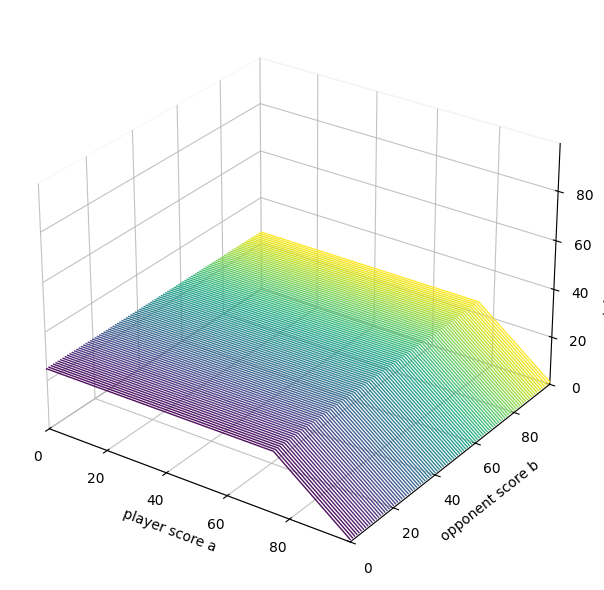

In [9]:
if True:
    policy_h25 = policy_hold_at_(25)
    
    policy_h25_a = policy_to_array_expanded(policy_h25)
    thr = threshold_surface(policy_h25_a)
    plot_surface(thr,'hold_at_25')    

# Assignment

## Dynamic Programming
**Choose and implement one algorithm**
* Policy Iteration and Improvement
* Value Iteration

## Dynamic Programming: Value Iteration & Bellman Equations



### 1. Action-Value: HOLD ($Q(s, \text{HOLD})$)
The **HOLD** action yields a deterministic transition. You bank your `turn` points, and play passes to the opponent. Because this is a zero-sum game, the value of the next state for you is the *negative* expected value for the opponent.
* **Immediate Win:** If $\text{me} + \text{turn} \ge \text{GOAL}$, then:
  $$Q(s, \text{HOLD}) = 1$$
* **Game Continues:** The next state from the opponent's perspective is $s' = (\text{opp}, \text{me} + \text{turn}, 0)$.
  $$Q(s, \text{HOLD}) = -\gamma \cdot V(\text{opp}, \text{me} + \text{turn}, 0)$$

### 2. Action-Value: ROLL ($Q(s, \text{ROLL})$)
The **ROLL** action creates a probability distribution over possible next states $s'$ (pig out, win, or continue turn). The expected value is the weighted sum of these outcomes.
$$Q(s, \text{ROLL}) = \sum_{s'} P(s' \mid s, \text{ROLL}) \left[ R(s, \text{ROLL}, s') + \gamma \cdot V_{\text{next}}(s') \right]$$
*(Note: $V_{\text{next}}(s')$ becomes $-V(s')$ if the outcome forces a turn swap, maintaining the zero-sum framing).*

### 3. Bellman Optimality Equation
To find the optimal state value $V(s)$, the DP algorithm compares the expected values of the two available actions and selects the maximum:
$$V(s) = \max \{ Q(s, \text{HOLD}), Q(s, \text{ROLL}) \}$$
The **optimal policy** $\pi^*(s)$ is simply the action ($\text{HOLD}$ or $\text{ROLL}$) that achieves this maximum value.

### 4. Convergence Criteria
The Value Iteration algorithm repeatedly sweeps through the state space, updating $V(s)$ using the Bellman equation above. The process halts when the maximum change in value across all states drops below a tiny threshold $\theta$:
$$\max_{s} |V_{\text{new}}(s) - V(s)| < \theta$$
Once this condition is met, the values are considered stable, meaning the optimal policy has officially converged.

In [10]:
@njit(fastmath=True)
def value_iteration(theta=1e-9, max_iters=2000, verbose=True):
    """
    Value iteration in current-player view.
    V(me, opp, turn) = expected discounted reward for current player (me).
    Hold: deterministic next state (bank and swap turn) -> value = -gamma*V(opp, me+turn, 0).
    Roll: expected value over outcomes (pig out / win / continue).
    """
    V = np.zeros((GOAL, GOAL, GOAL), dtype=np.float64)
    policy = np.zeros((GOAL, GOAL, GOAL), dtype=np.uint8)
    out_arr = OUT_ARR
    prob_arr = PROB_ARR

    for it in range(max_iters):
        delta = 0.0
        V_new = V.copy()
        for me in range(GOAL):
            for opp in range(GOAL):
                for turn in range(GOAL - me):
                    val_hold = GAMMA * (-V[opp, me + turn, 0])
                    val_roll = 0.0
                    for i in range(len(out_arr)):
                        d = out_arr[i]
                        p = prob_arr[i]
                        if GAME == GAME_PIG_DICE:
                            if d == PIG_OUT:
                                val_roll += p * GAMMA * (-V[opp, me, 0])
                            elif me + turn + d >= GOAL:
                                val_roll += p * 1.0
                            else:
                                val_roll += p * GAMMA * V[me, opp, turn + d]
                        else:
                            if d == PIGGYBACK:
                                val_roll += p * (-1.0)
                            elif d == OINKER:
                                val_roll += p * GAMMA * (-V[opp, 0, 0])
                            elif d == PIG_OUT:
                                val_roll += p * GAMMA * (-V[opp, me, 0])
                            elif me + turn + d >= GOAL:
                                val_roll += p * 1.0
                            else:
                                val_roll += p * GAMMA * V[me, opp, turn + d]
                    best = max(val_hold, val_roll)
                    delta = max(delta, abs(best - V[me, opp, turn]))
                    V_new[me, opp, turn] = best
                    if val_hold >= val_roll:
                        policy[me, opp, turn] = HOLD
                    else:
                        policy[me, opp, turn] = ROLL
        V = V_new
        if verbose and (it + 1) % 100 == 0:
            print("  iter", it + 1, "delta=", delta)
        if delta < theta:
            if verbose:
                print("  Converged at iteration", it + 1, "delta=", delta, "< theta=", theta)
            break
    return V, policy

def policy_iteration(theta=1e-9, max_iters=2000, verbose=True):
    """Stub: use value_iteration for this assignment."""
    return value_iteration(theta=theta, max_iters=max_iters, verbose=verbose)    

## Dynamic Programming (Value Iteration)

=== Dynamic Programming (Value Iteration) ===
  iter 100 delta= 0.0006691230021188821
  iter 200 delta= 1.5306410534321468e-06
  Converged at iteration 207 delta= 9.899134308100077e-07 < theta= 1e-06
time: 2.518315076828003
Saved 3D plot to: data/threshold_surface_3d_dyn_prog_game-0.png


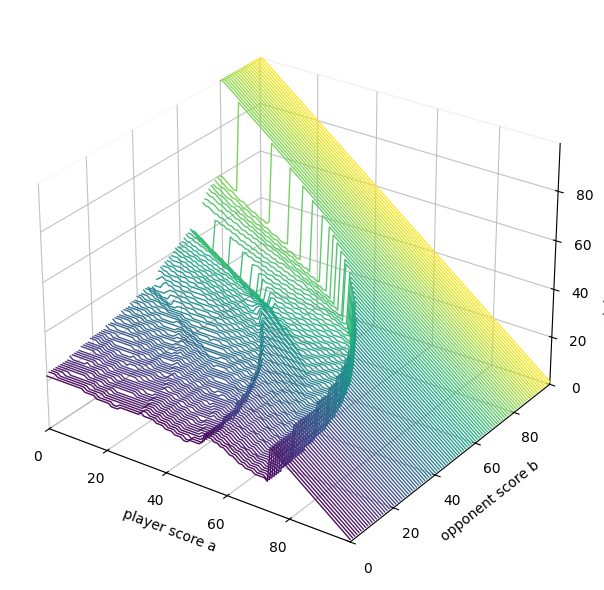

In [11]:
if True: # execute only when desired...
    THETA = 1e-6
    print("=== Dynamic Programming (Value Iteration) ===")
    _start = time.time()
    V_dp, policy_dp = value_iteration(theta=THETA, max_iters=2_000, verbose=True)
    print('time:',time.time()-_start)

    save_array(V_dp, filename=f"data/values_dyn_prog_game-{GAME}")
    save_array(policy_dp, filename=f"data/policy_dyn_prog_game-{GAME}")
    
    policy_dp_a = policy_to_array_expanded(policy_dp)
    thr = threshold_surface(policy_dp_a)
    plot_surface(thr,f'dyn_prog_game-{GAME}')

## Convergence, Policy Interpretation, Examples, and Sanity Checks

### Stopping Criterion and Convergence
Value iteration runs until the maximum change in value across all states drops below our defined threshold $\theta$:
$$\max |V_{\text{new}} - V| < \theta$$
For this implementation, we use $\theta = 10^{-6}$. Once this condition holds, the value function has effectively stopped changing, meaning the **policy has stabilized** (the same action—ROLL or HOLD—remains optimal at every state). The printed console message (e.g., `Converged at iteration k (delta=...)`) explicitly confirms this numerical criterion has been met.

### Interpreting the Policy (Threshold Surface)



The 3D plot visualizes the **minimal turn total ($t^*$)** at which the optimal action switches to **HOLD** for any given $(\text{me}, \text{opp})$ score combination. 
* **Below the threshold ($\text{turn} < t^*$):** The optimal action is **ROLL**.
* **At or above the threshold ($\text{turn} \ge t^*$):** The optimal action is **HOLD**.

**Key Structural Observations:**
* **Score Differential:** When you are ahead ($\text{me} > \text{opp}$), thresholds are lower—the policy plays conservatively to lock in the lead. When behind ($\text{me} < \text{opp}$), thresholds are higher—the policy takes aggressive risks to catch up.
* **Endgame Proximity:** Near the winning $\text{GOAL}$, holding dominates. If $\text{me} + \text{turn} \ge \text{GOAL}$, the policy holds immediately, regardless of how small the turn total is.
* **Trailing Behavior:** When significantly behind, the policy accepts much higher turn totals before holding, as the expected value of catching up outweighs the risk of a "pig out."

### Three Example States

1.  **Early Game:** $(\text{me}=0, \text{opp}=0, \text{turn}=0)$
    * **Action:** **ROLL**
    * **Reasoning:** With zero banked points and zero turn total, rolling carries no downside (you cannot lose accumulated points). The expected value of rolling (gaining points with a 5/6 probability) strictly exceeds the value of holding (scoring 0 and passing the turn).
2.  **Mid-Game:** $(\text{me}=50, \text{opp}=50, \text{turn}=20)$
    * **Action:** **HOLD** (Typically)
    * **Reasoning:** At parity, banking 20 points establishes a solid 70–50 lead. The policy balances risk and reward here; the threshold for holding generally hovers around 20 when scores are tied, securing the lead rather than risking a turn swap.
3.  **Near Win:** $(\text{me}=94, \text{opp}=80, \text{turn}=5)$
    * **Action:** **HOLD** (Almost Certainly)
    * **Reasoning:** Assuming $\text{GOAL} = 100$, you only need 6 points to win. Banking 5 points pushes you to 99, maintaining a massive lead. Rolling risks a "pig out" and surrenders a turn when victory is virtually guaranteed. The policy correctly prioritizes securing the near-certain advantage.

### Sanity Checks (Explicit Verification)



To ensure the policy's rationality, we verify the following baseline behaviors:
* **$\text{turn} = 0 \rightarrow$ Usually ROLL:** At the start of a turn, rolling is almost universally preferred because there are no accumulated points at risk.
* **Near Guaranteed Win $\rightarrow$ HOLD:** If $\text{me} + \text{turn} \ge \text{GOAL}$, holding locks in the victory. The policy strictly outputs HOLD in these terminal boundary regions.
* **Terminal State Exclusion:** States where $\text{me} \ge \text{GOAL}$ or $\text{opp} \ge \text{GOAL}$ are strictly terminal. They are handled directly by the $+1$ / $-1$ win/loss conditions in the Bellman updates and are mathematically excluded from the DP loop updates.
* **Strict Convergence:** The algorithm relies on the strict numerical bound ($\delta < \theta$), ensuring the loop terminates on mathematical stability rather than an arbitrary iteration cap.

In [12]:
# Evidence for the 3 example states (run after DP and policy_dp exist)
_action = lambda a: 'HOLD' if a == HOLD else 'ROLL'
for (me, opp, turn) in [(0, 0, 0), (50, 50, 20), (94, 80, 5)]:
    a = policy_dp[me, opp, turn]
    print(f"  State (me={me}, opp={opp}, turn={turn}) -> {_action(a)} (value={V_dp[me,opp,turn]:.4f})")

  State (me=0, opp=0, turn=0) -> ROLL (value=0.0308)
  State (me=50, opp=50, turn=20) -> HOLD (value=0.2868)
  State (me=94, opp=80, turn=5) -> ROLL (value=0.8467)
